<a href="https://colab.research.google.com/github/fnovoas/sinrepco/blob/main/Sinrepco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SINREPCO
por fnovoas@unal.edu.co

Para cargar un modelo de Sinrepco ya hecho (entrenado), saltamos directamente al **paso 8**. Podemos evaluarlo en el **paso 6**.

1. Instalamos las bibliotecas necesarias: TensorFlow para el desarrollo de modelos de inteligencia artificial, OpenCV para el procesamiento de imágenes y Tesseract para el reconocimiento óptico de caracteres (OCR).

In [1]:
!pip install tensorflow opencv-python pytesseract

2. Procedemos con la recolección de datos, reunimos un conjunto de datos que contiene imágenes de vehículos, tanto contaminantes como no contaminantes, estas imágenes fueron capturadas por mí en diversas ubicaciones. Contamos con 3381 imágenes de vehículos no chimenea y 280 imágenes de vehículos chimenea.
Separamos las imágenes según si contienen vehículos que emiten humo visible o no, en dos carpetas: "chimenea" y "no_chimenea". Con estos datos entrenaremos al modelo.\
Montamos Drive para acceder a las imágenes.


In [2]:
from google.colab import drive
import os

# Montar el Google Drive
drive.mount('/content/drive')

# Directorio base donde está la carpeta "sinrepco_fotos"
base_dir = "/content/drive/My Drive/sinrepco_fotos"

# Función para contar archivos en una carpeta
def contar_archivos_en_carpeta(carpeta):
    return len([f for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))])

# Recorrer todas las carpetas y subcarpetas en el directorio base
for root, dirs, files in os.walk(base_dir):
    for dir_name in dirs:
        carpeta_actual = os.path.join(root, dir_name)
        num_archivos = contar_archivos_en_carpeta(carpeta_actual)
        print(f"Carpeta encontrada: {carpeta_actual} - Archivos: {num_archivos}")

Mounted at /content/drive
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/no_chimenea - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/chimenea - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train/chimenea - Archivos: 196
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train/no_chimenea - Archivos: 2366
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation/chimenea - Archivos: 42
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation/no_chimenea - Archivos: 507
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test/chimenea - Archivos: 42
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test/no_chimenea - Archivos: 508


In [3]:
#importamos las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


3. **(Solo hace falta ejecutar este código cada vez que incorporemos nuevos datos, al hacerlo, deben estar guardados en las carpetas originales "chimenea" y "no_chimenea" en el directorio raíz respectivamente)** Cargamos y preparamos los datos de la carpeta en donde están almacenados en Drive. Este código divide las imágenes en conjuntos de entrenamiento, validación y prueba según el porcentaje especificado: el 70% de los datos irán en entrenamiento y el 15% en cada una de las otras dos categorías. Ejecutar este código cambia la estructura de la organización de los archivos y carpetas en Drive.

In [ ]:
import os
import random
import shutil
import time
# Crear directorios si no existen
base_dir = '/content/drive/My Drive/sinrepco_fotos'
source_chimenea = f'{base_dir}/chimenea'
source_no_chimenea = f'{base_dir}/no_chimenea'

train_chimenea_dir = f'{base_dir}/train/chimenea'
val_chimenea_dir = f'{base_dir}/validation/chimenea'
test_chimenea_dir = f'{base_dir}/test/chimenea'

train_no_chimenea_dir = f'{base_dir}/train/no_chimenea'
val_no_chimenea_dir = f'{base_dir}/validation/no_chimenea'
test_no_chimenea_dir = f'{base_dir}/test/no_chimenea'

os.makedirs(train_chimenea_dir, exist_ok=True)
os.makedirs(val_chimenea_dir, exist_ok=True)
os.makedirs(test_chimenea_dir, exist_ok=True)
os.makedirs(train_no_chimenea_dir, exist_ok=True)
os.makedirs(val_no_chimenea_dir, exist_ok=True)
os.makedirs(test_no_chimenea_dir, exist_ok=True)

def move_files(files, source, destination):
    for f in files:
        src_path = os.path.join(source, f)
        dest_path = os.path.join(destination, f)
        shutil.move(src_path, dest_path)
        # Verifica si el archivo se movió correctamente
        if not os.path.exists(dest_path):
            print(f"Reintentando mover: {f}")
            shutil.move(src_path, dest_path)
            # Da tiempo al sistema para procesar la operación
            time.sleep(0.1)

def move_data(SOURCE, TRAINING, VALIDATION, TEST, split_train=0.7, split_val_test=0.15):
    files = [f for f in os.listdir(SOURCE) if os.path.isfile(os.path.join(SOURCE, f))]
    print(f"Total files found in {SOURCE}: {len(files)}")  # Imprime el número total de archivos encontrados

    random.shuffle(files)

    train_size = int(len(files) * split_train)
    val_size = int(len(files) * split_val_test)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    print(f"Moving {len(train_files)} to {TRAINING}")  # Imprime cuántos archivos se moverán al entrenamiento
    print(f"Moving {len(val_files)} to {VALIDATION}")  # Imprime cuántos archivos se moverán a validación
    print(f"Moving {len(test_files)} to {TEST}")  # Imprime cuántos archivos se moverán a prueba

    # Mueve los archivos en lotes para evitar problemas con demasiadas operaciones a la vez
    batch_size = 100  # Ajusta este tamaño según sea necesario
    for i in range(0, len(train_files), batch_size):
        move_files(train_files[i:i+batch_size], SOURCE, TRAINING)

    for i in range(0, len(val_files), batch_size):
        move_files(val_files[i:i+batch_size], SOURCE, VALIDATION)

    for i in range(0, len(test_files), batch_size):
        move_files(test_files[i:i+batch_size], SOURCE, TEST)

# Ejecutar esta función para cada clase
move_data(source_chimenea, train_chimenea_dir, val_chimenea_dir, test_chimenea_dir)
move_data(source_no_chimenea, train_no_chimenea_dir, val_no_chimenea_dir, test_no_chimenea_dir)

Total files found in /content/drive/My Drive/sinrepco_fotos/chimenea: 280
Moving 196 to /content/drive/My Drive/sinrepco_fotos/train/chimenea
Moving 42 to /content/drive/My Drive/sinrepco_fotos/validation/chimenea
Moving 42 to /content/drive/My Drive/sinrepco_fotos/test/chimenea
Total files found in /content/drive/My Drive/sinrepco_fotos/no_chimenea: 3381
Moving 2366 to /content/drive/My Drive/sinrepco_fotos/train/no_chimenea
Moving 507 to /content/drive/My Drive/sinrepco_fotos/validation/no_chimenea
Moving 508 to /content/drive/My Drive/sinrepco_fotos/test/no_chimenea


Después de dividir los datos, configuramos el ImageDataGenerator para cargar las imágenes de estas nuevas carpetas:

In [4]:
#importamos las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import the ImageDataGenerator class
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
# Parámetros (reducir estos valores si nos quedamos sin RAM)
IMG_HEIGHT = 450
IMG_WIDTH = 600
BATCH_SIZE = 8

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f'{base_dir}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    f'{base_dir}/validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    f'{base_dir}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2562 images belonging to 2 classes.
Found 549 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


4. Ahora definimos la arquitectura de la CNN. Tomamos una estructura de red neuronal convolucional, que es adecuada para el análisis de imágenes.

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Definir la arquitectura de la CNN
model = Sequential([
    Input(shape=(450, 600, 3)),  # Especificamos la forma de entrada aquí
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

5. Entrenamos el modelo. Si bien el número de épocas recomendado normalmente (el número de veces que el modelo recorre todo el conjunto de datos para entrenarse) es de 20, usamos 7 para ajustarnos con el tiempo de ejecución máximo disponible.

In [6]:
EPOCHS = 7

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


321/321 ━━━━━━━━━━━━━━━━━━━━ 3018s 9s/step - accuracy: 0.8836 - loss: 1.7828 - val_accuracy: 0.9235 - val_loss: 0.2506
Epoch 2/7
321/321 ━━━━━━━━━━━━━━━━━━━━ 2927s 9s/step - accuracy: 0.9174 - loss: 0.2802 - val_accuracy: 0.9235 - val_loss: 0.2098
Epoch 3/7
321/321 ━━━━━━━━━━━━━━━━━━━━ 2962s 9s/step - accuracy: 0.9196 - loss: 0.1945 - val_accuracy: 0.9199 - val_loss: 0.2196
Epoch 4/7
321/321 ━━━━━━━━━━━━━━━━━━━━ 2966s 9s/step - accuracy: 0.9338 - loss: 0.1550 - val_accuracy: 0.9271 - val_loss: 0.2040
Epoch 5/7
321/321 ━━━━━━━━━━━━━━━━━━━━ 2957s 9s/step - accuracy: 0.9470 - loss: 0.1116 - val_accuracy: 0.9290 - val_loss: 0.2953
Epoch 6/7
321/321 ━━━━━━━━━━━━━━━━━━━━ 2945s 9s/step - accuracy: 0.9817 - loss: 0.0502 - val_accuracy: 0.8980 - val_loss: 0.2771
Epoch 7/7
321/321 ━━━━━━━━━━━━━━━━━━━━ 2966s 9s/step - accuracy: 0.9820 - loss: 0.0394 - val_accuracy: 0.9199 - val_loss: 0.6259


6. **Evaluamos** el modelo.
6.a. Gráficas de pérdida y exactitud.

69/69 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8978 - loss: 0.9835
Loss: 0.7722116112709045
Accuracy: 0.914545476436615


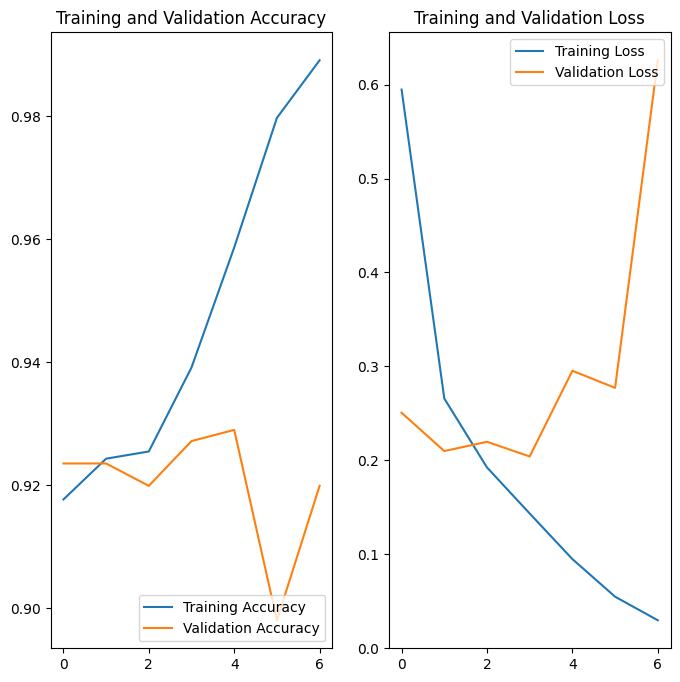

In [7]:
loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Graficar los resultados del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

6.b. Gráfica de matriz de confusión.

69/69 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step


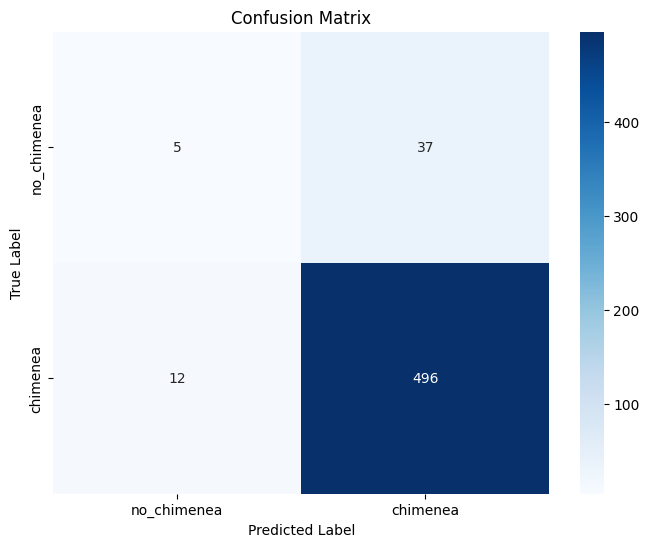

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones del conjunto de prueba
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int).flatten()  # Redondear a 0 o 1

# Obtener etiquetas verdaderas
y_true = test_generator.classes

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases
class_names = ['no_chimenea', 'chimenea']

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

6.c. Curvas ROC y AUC.

69/69 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step


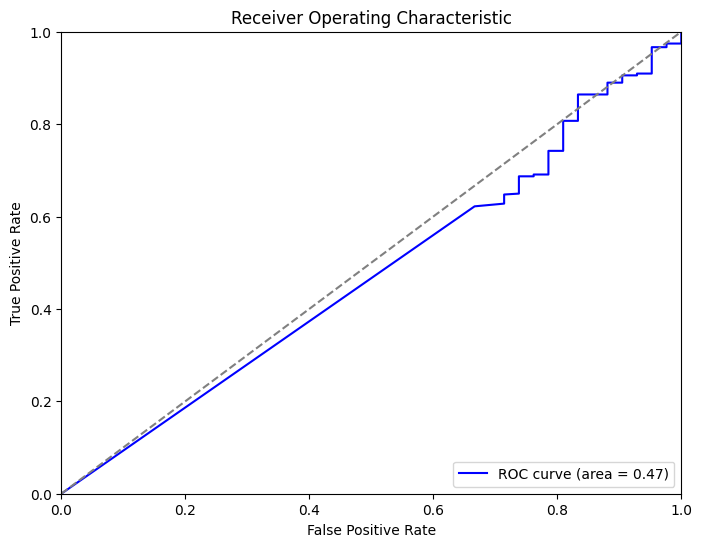

In [15]:
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades predichas
y_pred_prob = model.predict(test_generator).flatten()

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

6.d. Reporte de clasificación.

In [16]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 no_chimenea       0.29      0.12      0.17        42
    chimenea       0.93      0.98      0.95       508

    accuracy                           0.91       550
   macro avg       0.61      0.55      0.56       550
weighted avg       0.88      0.91      0.89       550



6.e. Curvas de pérdida y precisión **por época**.

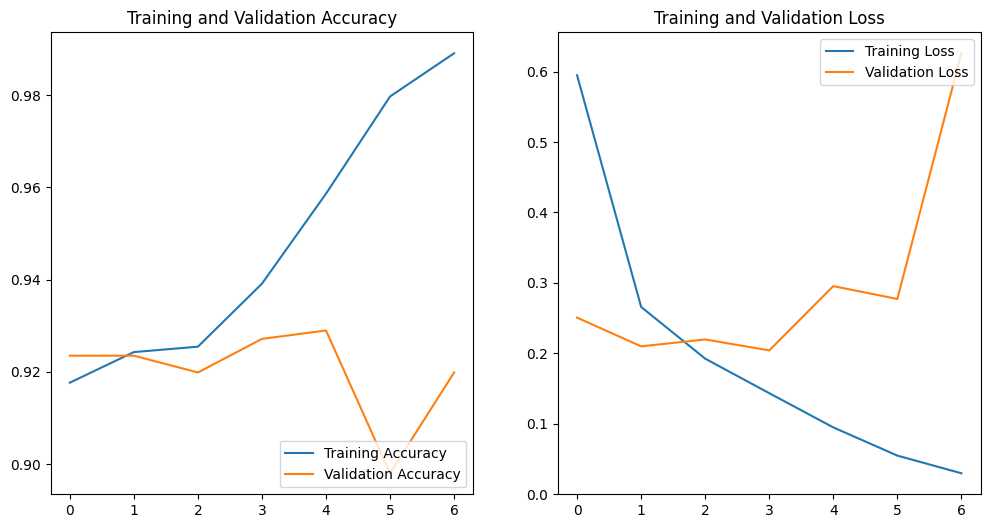

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

6.f. Gráfica de Precision-Recall

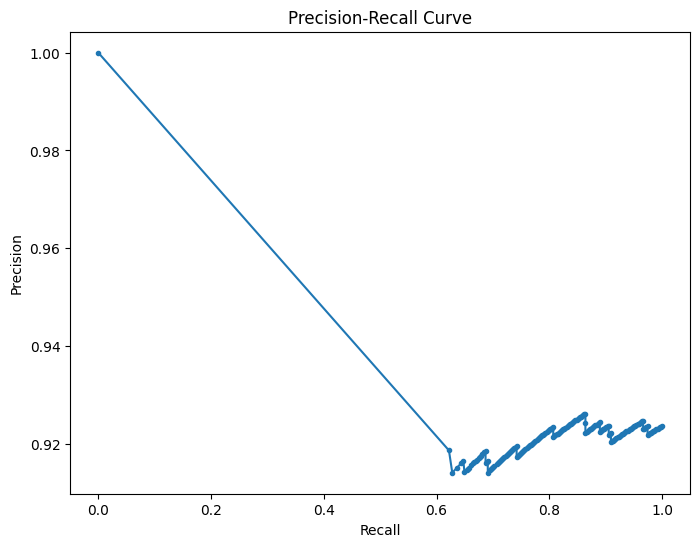

In [18]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

7. **Guardar** el modelo ya entrenado en Drive (para no tener que ejecutar el paso 5 nuevamente).

In [13]:
# Guardar el modelo en formato Keras nativo en la carpeta sinrepco_Fotos en Drive
model_path = '/content/drive/My Drive/sinrepco_fotos/saved_model.keras'

# Guardar el modelo entrenado en la ruta especificada
model.save(model_path)


7.a. Descargar el modelo en el equipo local (más demorado).

In [12]:
# Guardar el modelo en formato Keras nativo en el almacenamiento local de Colab
model_path = '/content/saved_model.keras'

# Guardar el modelo entrenado en la ruta especificada
model.save(model_path)

# Descargar el modelo a tu equipo
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8. **Cargar** el modelo a la sesión actual (para usar un modelo guardado anteriormente).

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/My Drive/sinrepco_fotos/saved_model.keras')